## Hotel Demand Forecasting - Occupancy Data Generation

Generate 4 years of daily occupancy data for a single hotel which has two categories fo rooms: standard and premium. The data generated consists of:

- For each room category: standard and suite
- Daily
- Room capacity
- Room rate
- Rooms occupied

The data attempts to simulate the variation of bookings and prices. Two CSV files will be produced:

- fitz_standard_rooms.csv
- fitz_premium_rooms.csv

The "Fitz" hotel has:

- Standard rooms: 254 at average £325
- Premium rooms: 100 at average £575

In [5]:
# Libraries
#

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
plt.style.use('ggplot')  


In [6]:
# Establish valid data file path, for reading and saving eg CSV files
#

import os
data_directory = 'Data_Sources'          # Designated data folder above the current working directory
project_directory = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(project_directory, data_directory)
if not os.path.isdir(DATA_PATH):
    raise Exception(f'Directory not found: {DATA_PATH}')


In [7]:
# Function to generate 4 years of daily time series data
#

def generate_daily_timeseries(trend_slope, seasonal_amplitude, noise_amplitude,
                              min_value, max_value,
                              special_dates):

    # 4 years date range, daily
    start_date='2020-01-01'
    end_date='2023-12-31'
    frequency = 'D'
    year = 365.25

    # Define the blank time series range and steps
    date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
    time = np.arange(len(date_range))

    # Generate a linear trend
    trend_component = trend_slope/year * time

    # Generate seasonality variation
    seasonal_cycle_annual = 2 * np.pi /year
    seasonal_component = seasonal_amplitude * np.sin(seasonal_cycle_annual * time )

    # Add Random noise
    noise_component = np.random.normal(0, noise_amplitude, len(date_range))

    # Create Time Series dataframe, indexed on the date
    base_value = max_value / 2
    time_series = base_value + trend_component + seasonal_component + noise_component
    df = pd.DataFrame({'Date': date_range[:len(time_series)], 'Value': time_series})
    df.set_index('Date', inplace=True)

    # Add special dates impact - take to the max value
    df.loc[special_dates, 'Value'] = max_value

    # Prevent min (typically 0) or exceeding max values and round to integers
    df['Value'] = df['Value'].clip(lower=min_value)
    df['Value'] = df['Value'].clip(upper=max_value)
    df['Value'] = df['Value'].round().astype(int)

    return df

Time series data saved to /Users/stuartgow/GitHub/Travel_Co_Analysis/Data_Sources/hotel_timeseries.csv


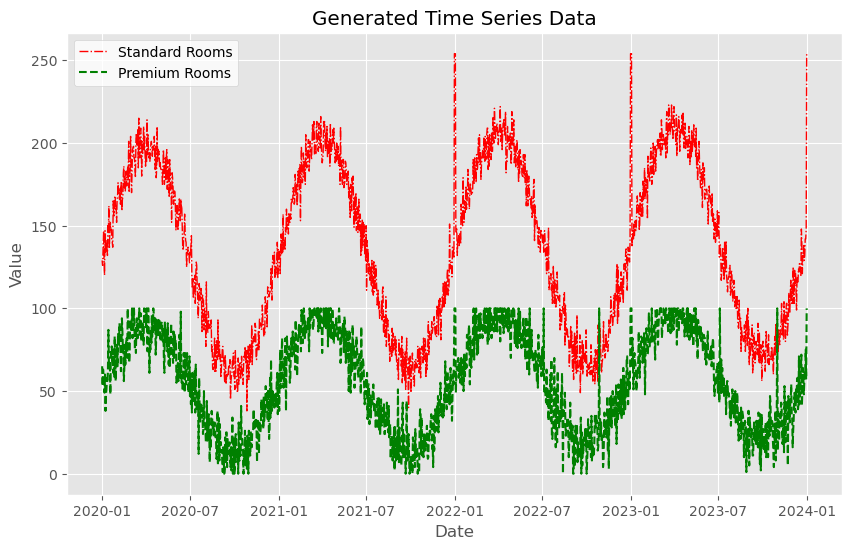

In [8]:
# Generate history for standard rooms

# Generate history for standard rooms with assumptions
rooms_min = 0
std_room_capacity = 254
std_avrg_rate = 325
std_special_events_on = ['2021-12-31', '2022-01-01', '2022-01-02', 
                     '2022-12-31', '2023-01-01', '2023-01-02', '2023-12-31']

standard_rooms = generate_daily_timeseries(trend_slope=4, seasonal_amplitude=70, noise_amplitude=8,
                                           min_value=rooms_min, max_value=std_room_capacity,
                                           special_dates=std_special_events_on)


# Generate history for premium rooms with assumptions
prm_room_capacity = 100
prm_avrg_rate = 575
prm_special_events_on = ['2021-12-31', '2022-01-01', '2022-01-02', '2022-07-04', '2022-10-27',
                     '2022-12-31', '2023-01-01', '2023-01-02', '2023-07-04', '2023-10-31',
                     '2023-12-31']


premium_rooms = generate_daily_timeseries(trend_slope=3, seasonal_amplitude=40, noise_amplitude=10,
                                           min_value=rooms_min, max_value=prm_room_capacity,
                                           special_dates=prm_special_events_on)

# Combine the room details into one dataframe
hotel_time_series = standard_rooms
hotel_time_series.rename(columns={'Value': 'Standard_OCC'}, inplace=True)
hotel_time_series['Standard_Capacity'] = std_room_capacity
hotel_time_series['Standard_Rate'] = std_avrg_rate

hotel_time_series['Premium_OCC'] = premium_rooms['Value']
hotel_time_series['Premium_Capacity'] = prm_room_capacity
hotel_time_series['Premium_Rate'] = prm_avrg_rate

# Save to CSV file
file_name = 'hotel_timeseries.csv'
file_path = os.path.join(DATA_PATH, file_name)
hotel_time_series.to_csv(file_path)
print(f'Time series data saved to {file_path}')

# Plot the timeseries
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title(f'Generated Time Series Data')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
# Two line plots
ax.plot(hotel_time_series.index, hotel_time_series['Standard_OCC'], linestyle='-.', color='red', linewidth=1, label='Standard Rooms')
ax.plot(hotel_time_series.index, hotel_time_series['Premium_OCC'], 'g--', label='Premium Rooms')
# Legend
ax.legend(loc='upper left', facecolor='white')
plt.show()
